In [5]:
import warnings
warnings.filterwarnings('ignore') 

import wfdb
import ast
import glob
import os
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

# Методы глубокого обучения в задаче предсказания степени инфаркта 

## Введение

По статистике каждый год от сердечно-сосудистых заболеваний умирает около 17,5 миллионов человек [[6](#references)], поэтому преждевременное обнаружение сердечно-сосудистых заболеваний является очень важной проблемой. Одним из наиболее опасных среди сердечно-сосудистых заболеваний является инфаркт миокарда. Для того чтобы обнаружить инфаркт миокарда врач анализирует результаты ЭКГ. Однако современный технологический прогресс с каждым днём развивается настолько быстро, что машины уже научились с помощью различных методов анализировать результаты электрокардиографии и с определённой точностью диагностировать инфаркт миокарда и другие заболевания.

Электрокардиография (ЭКГ) - это ключевой неинвазивный диагностический инструмент сердечно-сосудистых заболеваний. Все больше поддерживается алгоритмами на основе машинного обучения. Основные препятствия для развития алгоритмов автоматической интерпретации ЭКГ - это как отсутствие общедоступных наборов данных, так и четко определенные процедуры тестирования, позволяющие сравнивать разные алгоритмы. Для решения этих проблем мы будем использовать *PTB-XL* [[1](#references)], самый большой на сегодняшний день бесплатный клинический набор данных ЭКГ.

## 1. Постановка учебно-практической задачи

Целью данной работы является создание и тренировка различных моделей, базирующихся на методах глубокого обучения, и сравнение метрик качества, которые позволяют сравнивать модели между собой и выбирать оптимальные.

Для достижения этой цели планируется выполнить следующие задачи:

- Провести исследование набора данных PTB-XL, выполнив предобработку данных.
- Обработать данные сигнала
- Создать модель, с помощью методов глубокого обучения
- Для каждой модели подобрать гиперпараметры, чтобы получить наилучшие результаты

## 2. Набор данных

В этом разделе мы кратко представляем набор данных *PTB-XL* [[1](#references)], который лежит в основе экспериментов, представленных ниже. Набор данных PTBXL включает 21837 клинических записей ЭКГ в 12 отведениях продолжительностью 10 секунд от 18885 пациентов, из которых 52% составляли мужчины и 48% - женщины. Заявления ЭКГ, используемые для аннотации, соответствуют стандарту SCP-ECG [[7](#references)] и были отнесены к трем не исключающим друг друга категориям:

- диагностика (diag)

- форма (form)

- ритм (rhythm)

Всего существует 71 различное заявление, которые содержат 44 диагностических, 12 ритмических и 19 формальных заявлений. Обратите внимание, что есть 4 заявления формы, которые также назначаются набору диагностических заявлений ЭКГ.
Для диагностических заявлений также предусмотрена иерархическая структура в пять суперклассов и 24 подкласса.

Суперклассы:
- NORM: нормальная ЭКГ
- CD: нарушение проводимости
- MI: инфаркт миокарда
- HYP: гипертрофия
- STTC: изменения ST / T

Чтобы проиллюстрировать универсальность задач, которые могут быть решены в наборе данных, мы также включаем дополнительные данные, а именно демографическую информацию, такую как возраст и пол, а также рост и вес пациентов.

## 3. Предобработка данных

С помощью функции `load_raw_data` и модуля *wfdb* загрузим данные сигнала в виде numpy.array и сохраним в *X*. В *Y* будем хранить набор данных PTB-XL.
С помощью функции aggregate_diagnostic достанем из класса *scp_codes*, который представлен в виде словаря, список суперклассов. 

In [6]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data


path = 'D:/Учеба/Magistracy/Research work/PTB XL/'
sampling_rate=100

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

data = [wfdb.rdsamp(path+f) for f in Y.filename_lr]
X = load_raw_data(Y, sampling_rate, path)

agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

Построим графики ЭКГ в 12 отведениях для одной записи

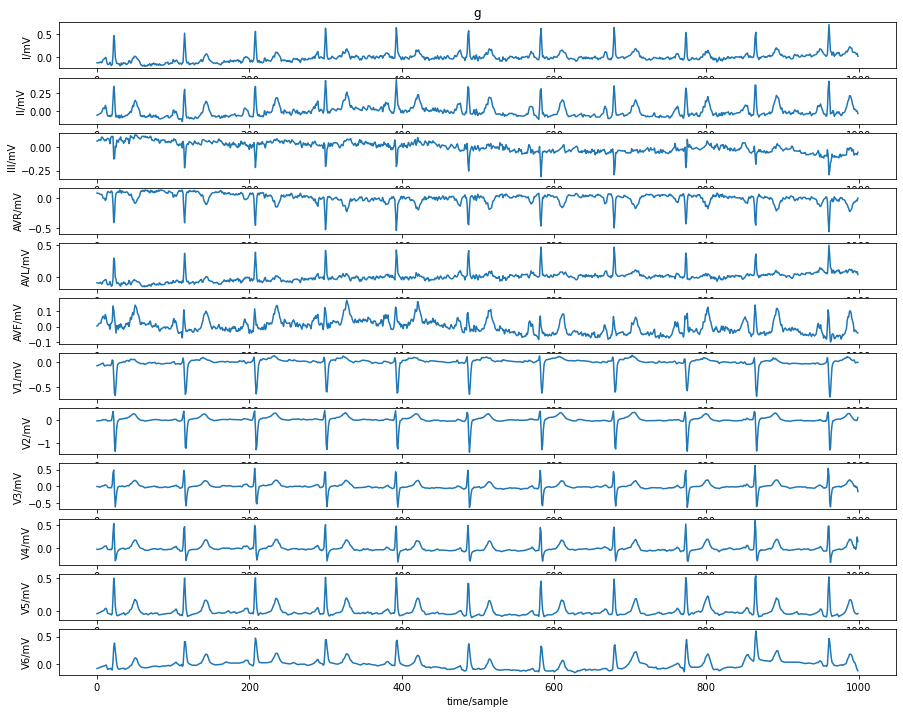

In [7]:
record = wfdb.rdrecord('D:/Учеба/Magistracy/Research work/PTB XL/records100/00000/00001_lr') 
wfdb.plot_wfdb(record=record, title='g', figsize=(15, 12)) 

In [8]:
Y.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]


In [9]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass'],
      dtype='object')

Для классификации инфаркта миокарда, отбросим столбцы с ненужными для классификации данными

In [10]:
Y.drop(['patient_id','nurse', 'site','device', 'recording_date', 'report', 'scp_codes',
        'heart_axis', 'validated_by','second_opinion', 'initial_autogenerated_report',
        'validated_by_human','baseline_drift', 'static_noise', 'burst_noise',
        'electrodes_problems','extra_beats', 'pacemaker','filename_hr'], axis='columns', inplace=True)

In [11]:
Y.head()

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,strat_fold,filename_lr,diagnostic_superclass
ecg_id,,,,,,,,,
1,56.0,1,NaN,63.0,NaN,NaN,3,records100/00000/00001_lr,[NORM]
2,19.0,0,NaN,70.0,NaN,NaN,2,records100/00000/00002_lr,[NORM]
3,37.0,1,NaN,69.0,NaN,NaN,5,records100/00000/00003_lr,[NORM]
4,24.0,0,NaN,82.0,NaN,NaN,3,records100/00000/00004_lr,[NORM]
5,19.0,1,NaN,70.0,NaN,NaN,4,records100/00000/00005_lr,[NORM]


In [12]:
Y.tail()

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,strat_fold,filename_lr,diagnostic_superclass
ecg_id,,,,,,,,,
21833,67.0,1,NaN,NaN,NaN,NaN,7,records100/21000/21833_lr,[STTC]
21834,93.0,0,NaN,NaN,Stadium II-III,NaN,4,records100/21000/21834_lr,[NORM]
21835,59.0,1,NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,[STTC]
21836,64.0,1,NaN,NaN,NaN,NaN,8,records100/21000/21836_lr,[NORM]
21837,68.0,0,NaN,NaN,NaN,NaN,9,records100/21000/21837_lr,[NORM]


In [13]:
Y['infarction_stadium1'].unique()

array([nan, 'unknown', 'Stadium II-III', 'Stadium III', 'Stadium I',
       'Stadium II', 'Stadium I-II'], dtype=object)

In [14]:
Y['infarction_stadium2'].unique()

array([nan, 'Stadium I', 'Stadium II', 'Stadium III'], dtype=object)

In [15]:
Y.isna().sum()

age                         89
sex                          0
height                   14854
weight                   12408
infarction_stadium1      16211
infarction_stadium2      21734
strat_fold                   0
filename_lr                  0
diagnostic_superclass        0
dtype: int64

Заменим значения `nan` в классах *weight*, *height*, *age* на `-1`, а в классах *infarction_stadium1*, *infarction_stadium2*, на `Healthy`.

In [16]:
Y['weight'] = Y['weight'].fillna(-1) 

In [17]:
Y['height'] = Y['height'].fillna(-1) 

In [18]:
Y['age'] = Y['age'].fillna(-1) 

In [19]:
Y['infarction_stadium1'] = Y['infarction_stadium1'].fillna('Healthy') 

In [20]:
Y['infarction_stadium2'] = Y['infarction_stadium2'].fillna('Healthy')

In [21]:
Y.isna().sum()

age                      0
sex                      0
height                   0
weight                   0
infarction_stadium1      0
infarction_stadium2      0
strat_fold               0
filename_lr              0
diagnostic_superclass    0
dtype: int64

Пока что будем работать только со II-отведением:

In [22]:
data = Y
signal_data = X[:,:,1]

In [23]:
signal_data.shape

(21837, 1000)

Данные сигнала мы загружали в виде numpy.array, переопределим тип и создадим dataframe

In [24]:
signal_data

array([[-0.055, -0.051, -0.044, ...,  0.   ,  0.004, -0.031],
       [ 0.138,  0.116,  0.092, ...,  0.398,  0.057, -0.056],
       [-0.079, -0.07 , -0.057, ..., -0.226, -0.266, -0.288],
       ...,
       [ 0.024,  0.066, -0.006, ..., -0.062,  0.026,  0.53 ],
       [-0.057, -0.029,  0.045, ...,  0.07 ,  0.082,  0.051],
       [-0.025, -0.029, -0.042, ...,  0.012,  0.022, -0.007]])

In [25]:
sd = pd.DataFrame(signal_data, index=range(1, signal_data.shape[0] + 1),
                  columns=range(1, signal_data.shape[1] + 1))

Соединим две таблицы с данными сигнала и данными о пациентах, чтобы добавить классы *age*, *sex*, *height*, *weight*.

In [26]:
signal_data = pd.concat([sd, data], axis=1)

In [27]:
signal_data.drop(['filename_lr','infarction_stadium1', 'infarction_stadium2','diagnostic_superclass', 'strat_fold'],
                 axis='columns', inplace=True)

In [28]:
signal_data

,1,2,3,4,5,6,7,8,9,10,...,995,996,997,998,999,1000,age,sex,height,weight
1,-0.055,-0.051,-0.044,-0.038,-0.031,-0.025,-0.014,0.008,0.044,0.045,...,0.023,0.028,0.021,0.000,0.004,-0.031,56.0,1,-1.0,63.0
2,0.138,0.116,0.092,0.089,0.083,0.076,0.078,0.080,0.081,0.092,...,0.792,1.320,0.773,0.398,0.057,-0.056,19.0,0,-1.0,70.0
3,-0.079,-0.070,-0.057,-0.120,-0.061,-0.017,0.251,0.572,0.248,-0.035,...,-0.251,-0.240,-0.234,-0.226,-0.266,-0.288,37.0,1,-1.0,69.0
4,-0.138,-0.156,-0.153,-0.161,-0.193,-0.190,-0.182,-0.161,-0.138,-0.134,...,-0.981,-0.965,-0.928,-0.915,-0.910,-0.899,24.0,0,-1.0,82.0
5,-0.574,-0.575,-0.584,-0.592,-0.588,-0.590,-0.590,-0.588,-0.619,-0.609,...,0.218,0.180,0.164,0.160,0.157,0.148,19.0,1,-1.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,-0.034,-0.027,-0.019,-0.005,0.002,0.043,0.103,0.095,0.068,0.003,...,-0.090,0.039,0.045,-0.028,-0.029,-0.057,67.0,1,-1.0,-1.0
21834,-0.013,0.008,0.047,0.056,0.015,-0.007,-0.035,-0.089,-0.087,-0.094,...,-0.110,-0.104,-0.144,-0.130,0.194,0.349,93.0,0,-1.0,-1.0
21835,0.024,0.066,-0.006,0.085,0.169,0.121,0.169,0.103,0.067,0.059,...,0.367,0.004,0.055,-0.062,0.026,0.530,59.0,1,-1.0,-1.0
21836,-0.057,-0.029,0.045,0.058,0.087,0.098,0.077,0.079,0.049,-0.011,...,0.239,0.189,0.119,0.070,0.082,0.051,64.0,1,-1.0,-1.0


In [29]:
data.drop(['age', 'sex', 'height', 'weight', 'filename_lr', 'diagnostic_superclass'], axis='columns', inplace=True)

In [30]:
data

,infarction_stadium1,infarction_stadium2,strat_fold
ecg_id,,,
1,Healthy,Healthy,3
2,Healthy,Healthy,2
3,Healthy,Healthy,5
4,Healthy,Healthy,3
5,Healthy,Healthy,4
...,...,...,...
21833,Healthy,Healthy,7
21834,Stadium II-III,Healthy,4
21835,Healthy,Healthy,2


#### 3.1. Обработка категориальных признаков

С помощью `get_dummies` обработаем категориальные признаки.`get_dummies` создаст новый столбец для каждого уникального категориального значения. Он поместит единицу в столбец, соответствующий категориальному значению для этого наблюдения.

In [31]:
dummies_inf1 = pd.get_dummies(data['infarction_stadium1'])
data = pd.concat((data, dummies_inf1), axis=1)
data = data.drop(['infarction_stadium1'],  axis=1)

In [32]:
#dummies_inf2 = pd.get_dummies(data['infarction_stadium2'])
#data = pd.concat((data, dummies_inf2), axis=1)
data = data.drop(['infarction_stadium2'],  axis=1)

In [33]:
data

,strat_fold,Healthy,Stadium I,Stadium I-II,Stadium II,Stadium II-III,Stadium III,unknown
ecg_id,,,,,,,,
1,3,1,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0
3,5,1,0,0,0,0,0,0
4,3,1,0,0,0,0,0,0
5,4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
21833,7,1,0,0,0,0,0,0
21834,4,0,0,0,0,1,0,0
21835,2,1,0,0,0,0,0,0


#### 3.2. Разделение на тестовый и тренировочный набор данных

Изначально данные разделены на 10 групп. Разделим данные на тренировочный и тестовый набор по классу `strat_fold`. 

In [34]:
x_train = signal_data[data.strat_fold <= 9]
y_train = data[data.strat_fold <= 9]

x_test = signal_data[data.strat_fold == 10]
y_test = data[data.strat_fold == 10]

In [35]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((19634, 1004), (2203, 1004), (19634, 8), (2203, 8))

In [36]:
y_train = y_train.drop(['strat_fold'], axis=1)
y_test = y_test.drop(['strat_fold'], axis=1)

#### 3.3. Обработка численных признаков

Чтобы нормализовать численные признаки, воспользуемся линейным преобразованием, приводящим все значения к нулевому среднему и единичному стандартному отклонению.

In [37]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test  = ss.transform(x_test)

#### 3.4. Применение классификатора Random Forest

Для теста, воспользуемся классификатором Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=110, max_depth=10, random_state=101)
rfc.fit(x_train, y_train)
print("Train accuracy :", rfc.score(x_train, y_train))
print("Test accuracy :", rfc.score(x_test, y_test))

Train accuracy : 0.7433533666089437
Test accuracy : 0.7394462097140263


Построим матрицу ошибок

In [48]:
from sklearn.metrics import multilabel_confusion_matrix
y_pred = rfc.predict(x_test)
multilabel_confusion_matrix(y_test, y_pred)

array([[[  29,  533],
        [  12, 1629]],

       [[2189,    0],
        [  14,    0]],

       [[2203,    0],
        [   0,    0]],

       [[2196,    0],
        [   7,    0]],

       [[2096,    0],
        [ 107,    0]],

       [[2103,    0],
        [ 100,    0]],

       [[1869,    0],
        [ 334,    0]]], dtype=int64)

In [49]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore') 
print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.75      0.99      0.86      1641
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00       107
           5       0.00      0.00      0.00       100
           6       0.00      0.00      0.00       334

   micro avg       0.75      0.74      0.75      2203
   macro avg       0.11      0.14      0.12      2203
weighted avg       0.56      0.74      0.64      2203
 samples avg       0.74      0.74      0.74      2203



Мы смогли убедится, что данный классификатор, не подходит для нашей задачи, так как для большинства классов такие метрики как precision, recall, f1-score равны 0.

## 4. Реализация сверточной нейронной сети (CNN)

Попробуем построить модель сверточной нейронной сети и обучить ее. Будем использовать 5 сверточных слоев, 2 полносвязных слоя и слой softmax. На каждом слое свертки будем применять одномерную свертку во времени, и каждая из них имеет 32 ядра размера 5. Мы также используем max pooling размера 5 c шагом 2 во всех pooling слоях. Полносвязные слои будут иметь 32 нейрона. Подбор оптимальных параметров будет реализован позже, сейчас это первая попытка реализовать сверточную нейронную сеть, опираясь на статьи [[2](#references)], [[3](#references)], [[4](#references)], [[5](#references)].

После того как модель будет сконструирована, настроим процесс ее обучения вызовом метода `compile`, используя параметры метода:
 - optimizer: Adam с коэффициентом скорости обучения = 0.001, этот параметр позволяет определить процедуру обучения
 - loss: categorical_crossentropy , эта функция которая минимизируется в процессе обучения
 - metrics: accuracy и AUC, используются для мониторинга обучения.

In [40]:
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K

In [41]:
n_obs, feature = x_train.shape
depth = 1
batch_size = 32

In [42]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S21)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(7)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1004, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1000, 32)     192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 32)     5152        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1000, 32)     0           conv1d_1[0][0]                   
_______________________________________________________________________________________

In [43]:
history = model.fit(x_train, y_train, epochs=40, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/40
614/614 [==============================] - 90s 146ms/step - loss: 0.7946 - accuracy: 0.7456 - auc: 0.9460 - val_loss: 0.7384 - val_accuracy: 0.7567 - val_auc: 0.9530
Epoch 2/40
614/614 [==============================] - 92s 149ms/step - loss: 0.7262 - accuracy: 0.7616 - auc: 0.9540 - val_loss: 0.7141 - val_accuracy: 0.7571 - val_auc: 0.9561
Epoch 3/40
614/614 [==============================] - 91s 148ms/step - loss: 0.7060 - accuracy: 0.7658 - auc: 0.9565 - val_loss: 0.7142 - val_accuracy: 0.7581 - val_auc: 0.9575
Epoch 4/40
614/614 [==============================] - 90s 147ms/step - loss: 0.6946 - accuracy: 0.7694 - auc: 0.9578 - val_loss: 0.7281 - val_accuracy: 0.7549 - val_auc: 0.9544
Epoch 5/40
614/614 [==============================] - 91s 148ms/step - loss: 0.6830 - accuracy: 0.7711 - auc: 0.9594 - val_loss: 0.7145 - val_accuracy: 0.7535 - val_auc: 0.9560
Epoch 6/40
614/614 [==============================] - 91s 148ms/step - loss: 0.6719 - accuracy: 0.7756 - auc: 0.960

In [46]:
def evaluate_model(history, x_test, y_test, model):
    scores = model.evaluate((x_test), y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1] * 100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Test'], loc='lower right')
    plt.show()

Accuracy: 72.67%


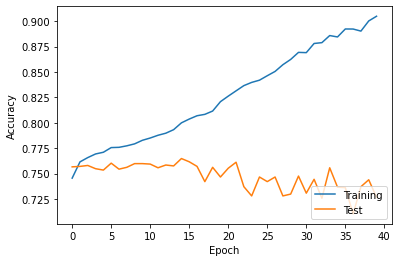

In [47]:
evaluate_model(history, x_test, y_test, model)
y_pred=model.predict(x_test)

## Заключение

На данный момент можно сделать следующие выводы:

- Произведена предварительная обработка набора данных и сигнала

- Экспериментально убедились, что классификатор Случайный лес не подходит для данной задачи

- Из графика зависимости достоверности модели и количества эпох видно, что достоверность модели для тренировочного набора данных растет с каждой эпохой, а для тестового набора, точность уменьшается и колеблится от 70 до 73 процентов. Такая большая разница между тестовым набором и тренировочным связана с высоким переобучением.

То, что будет выполнено позже:

- Рассмотрены другие метрики

- Борьба с переобучением

- Поиск оптимальных параметров для CNN

- Реализация других моделей


## Список литературы <a id='references'></a>

1. Patrick Wagner, Nils Strodthoff, Ralf-Dieter Bousseljot, Dieter Kreiseler, Fatima I.Lunze, Wojciech Samek, and Tobias Schaeffter. Ptb-xl, a large publicly available electrocardiography dataset. Scientific Data, 7(1):1–15, 2020.


2. Victor Moskalenko, Nikolai Zolotykh, and Grigory Osipov. Deep learning for ecg segmentation. In International Conference on Neuroinformatics, pages 246–254. Springer, 2019.


3. Kachuee Mohammad and Fazeli Shayan and Sarrafzadeh Majid. Ecg heartbeat classification: A deep transferable representation. 2018 IEEE International Conference on Healthcare Informatics (ICHI), pages 443-444. IEEE, 2018.


4. Feng Kai. Myocardial infarction classification based on convolutional neural network and recurrent neural network. Applied Sciences, 9(9):1879, 2019


5. Nils Strodthoff and Claas Strodthoff. Detecting and interpreting myocardial infarction using fully convolutional neural networks. Physiological measurement, 20(1):015001, 2019.


6. World Health Organization. Fight cardiovascular disease. 2018. URL https://www.who.int/cardiovascular_diseases/ru/.


7. ISO Central Secretary, “Health informatics – Standard communication protocol – Part 91064: Computer-assisted electrocardiography,” International Organization for Standardization, Geneva, CH, Standard ISO 11073-91064:2009, 2009.